In [ ]:
# install

!pip install konlpy
!pip install wandb
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!pip install -q -U keras-tuner
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!pip install transformers==4.4.1
!pip install tokenizers==0.10.1

Cloning into 'Mecab-ko-for-Google-Colab.git]'...
fatal: unable to access 'https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git]/': The requested URL returned error: 400
[Errno 2] No such file or directory: 'Mecab-ko-for-Google-Colab'
/content
bash: install_mecab-ko_on_colab190912.sh: No such file or directory


In [ ]:
# import 

import numpy as np
import pandas as pd
import re
import shutil
import os
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import matplotlib.pyplot as plt
import time
import tensorflow_datasets as tfds
from konlpy.tag import Komoran
import collections
import sys
import nltk
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model
import datetime
import keras
from keras.callbacks import EarlyStopping
import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab 
import nltk.translate.bleu_score as bleu
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizerFast
from sklearn.model_selection import KFold
import kerastuner as kt
import IPython
nltk.download('punkt')
komoran = Komoran()
#mecab = Mecab().morphs

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# drive mount

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data preprocessing

class Kor2EngData:
    def __init__(self, data_dir):
        self.files = os.listdir(data_dir)
        self.files = [os.path.join(data_dir, f) for f in self.files]
        self.eng = []
        self.kor = []
        self.datas = []
        
    def data_processing(self):
        self.make_data_to_list()
        self.split_eng_kor()
        
        return self.eng, self.kor
        
    def make_data_to_list(self):
        for file in self.files:
            try:
                with open(file, 'r', encoding='cp949') as f:
                    all_data = f.readlines()
                    
                    for data in all_data:
                        data = data.replace('\n', '')
                        data = data.replace('#', '')
                                       
                        if len(data) != 0:
                            self.datas.append(data)
            except:
                pass
        
    def split_eng_kor(self):        
        for i in range(len(self.datas) - 3):
            if self.datas[i][0] == '[':
                if self.datas[i + 3][0] == '[': 
                    self.eng.append(clean_text(self.datas[i + 1]))
                    self.kor.append(clean_text(self.datas[i + 2]))
                    

    def make_dictionary(self, data, Korean=False):
        words = []
        for sentence in data:
            if not Korean:
                tokens = nltk.word_tokenize(sentence)
                            
            else:
                tokens = komoran.morphs(sentence)
              # tokens = mecab(sentence)
            for word in tokens:
                if has_number(word):
                    tokens.remove(word)
                        
            words.extend(tokens)

        words = collections.Counter(words)

        dictionary = {}
        dictionary['<PAD>'] = 0
        dictionary['<UNK>'] = 1
        dictionary['<EOS>'] = 2
        dictionary['<S>'] = 3
        idx = 4
        for word in words.most_common():
            if len(word[0]) > 0:
                dictionary[word[0]] = idx
                idx += 1
            
            #if idx >= 20000: break;

        return dictionary
    
def clean_text(text):
    return re.sub('[\{\}\[\]\/,;:|\)*~`^\-_+<>@\#$%&\\\=\(\"“”◀▶【©】☎]', '', text.lower())

def has_number(word):
    return any(char.isdigit() for char in word)

data_directory = "./drive/My Drive/comic_trans_project/data"
MAX_LENGTH = 0

kor2eng = Kor2EngData(data_directory)
eng, kor = kor2eng.data_processing()

eng_dict = kor2eng.make_dictionary(eng)
kor_dict = kor2eng.make_dictionary(kor, True)

output_dict = {y:x for x,y in eng_dict.items()}
input_dict = {y:x for x,y in kor_dict.items()}

eng_dict_size = len(eng_dict)
kor_dict_size = len(kor_dict)

eng_df = pd.DataFrame(eng, columns=['English'])
kor_df = pd.DataFrame(kor, columns=['Korean'])
kor2eng = pd.concat([eng_df, kor_df], axis=1)

for i, eng in enumerate(kor2eng['English']):
    if len(eng) > MAX_LENGTH:
        kor2eng.drop(kor2eng.index[i])
for i, kor in enumerate(kor2eng['Korean']):
    if len(kor) > MAX_LENGTH:
        kor2eng.drop(kor2eng.index[i])

print("English Dictionary Size: ", eng_dict_size)
print("Korean Dictionary Size: ", kor_dict_size)

In [ ]:
# vectorizing

def vectorize_data(data, dictionary, Korean=False, target=False):
    max_len = 0
    vec_sentence = []

    for sentence in data:
        temp = []
        
        #temp.append(dictionary['<S>'])
        
        if not Korean:
            if not target :
                temp.append(dictionary['<S>'])
            for word in nltk.word_tokenize(sentence):
                if len(word) > 0:
                    if word in dictionary:
                        temp.append(dictionary[word])
                    else:
                        temp.append(dictionary['<UNK>'])
            if target :
              temp.append(dictionary['<EOS>'])
        else:
            for word in komoran.morphs(sentence):
                if len(word) > 0:
                    if word in dictionary:
                        temp.append(dictionary[word])
                    else:
                        temp.append(dictionary['<UNK>'])
          
        if max_len < len(temp):
            max_len = len(temp)

        vec_sentence.append(temp)
        
    return vec_sentence, max_len

def add_padding(vec_data, max_len):
    for sentence in vec_data:
        for i in range(len(sentence), max_len + 1):
            sentence.append(0)
    
    return np.array(vec_data)

kor_vec, kor_max = vectorize_data(kor2eng['Korean'], kor_dict, Korean = True)
eng_vec_input, eng_max = vectorize_data(kor2eng['English'], eng_dict)
eng_vec_target, eng_max = vectorize_data(kor2eng['English'], eng_dict, target=True)

encoder_input = add_padding(kor_vec, kor_max)
decoder_input = add_padding(eng_vec_input, eng_max)
decoder_target = add_padding(eng_vec_target, eng_max)

In [ ]:
print(encoder_input[3])
print(decoder_input[3])
print(decoder_target[3])

[ 135    7  110   49   12 4594    8   18   41    9 4032  112    6   24
   45  179    4   44    7   46  133   13  834   28   52   40    7   89
   32   22    4    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[    3   288 13310    13    90    27   292    36   597    59     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
[  288 13310    13    90    27   292    36   597    59     2     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]


In [ ]:
encoder_input.shape, decoder_input.shape, decoder_target.shape

((60557, 66), (60557, 29), (60557, 29))

In [ ]:
# data split

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

print(encoder_input[30997])
print(decoder_input[30997])
print(decoder_target[30997])

[29309 43309 21244 ... 53161 32802  7628]
[1049  107   36    7  211  433    6    5    4    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[   3 1564  276   32   42  279    4    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
[1564  276   32   42  279    4    2    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [ ]:
n_of_val = int(60557*0.1)
print(n_of_val)

6055


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(54502, 66)
(54502, 29)
(54502, 29)
(6055, 66)
(6055, 29)
(6055, 29)


In [ ]:
# 모델링 

# latent_space
latent_dim = 100

# 인코더
encoder_inputs = Input(shape=(None,))

# 임베딩 층
enc_emb =  Embedding(kor_dict_size, latent_dim)(encoder_inputs) 

# 패딩 0은 연산에서 제외
enc_masking = Masking(mask_value=0.0)(enc_emb) 

# LSTM모델 사용 
encoder_lstm = LSTM(latent_dim, return_state=True) 

# hidden state, cell state
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) 
encoder_states = [state_h, state_c] 

# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(eng_dict_size, latent_dim) 
dec_emb = dec_emb_layer(decoder_inputs) 
dec_masking = Masking(mask_value=0.0)(dec_emb)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 

# 인코더의 hidden state를 initial_state로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(eng_dict_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    1755700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    2831000     input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
checkpoint_filepath = "./drive/My Drive/comic_trans_project/checkpoints/seq_komoran.hdf5"
save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch', options=None)
early_stopping = EarlyStopping(monitor='loss', mode='auto', verbose=1, patience=10)

In [ ]:
!wandb login eb738ba304b560fc8b41bf28ba686d71a2b3d5d4
wandb_project = "seq_komoran"
wandb_group = "seq_komoran"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project=wandb_project) 
wandb_callback = WandbCallback()

history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 50, callbacks=[save_best, early_stopping, wandb_callback])

wandb: Currently logged in as: mugan (use `wandb login --relogin` to force relogin)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
426/426 [==============================] - 52s 107ms/step - loss: 2.4301 - acc: 0.7015 - val_loss: 1.9122 - val_acc: 0.7332

Epoch 00001: loss improved from inf to 2.43011, saving model to ./drive/My Drive/comic_trans_project/checkpoints/seq_komoran.hdf5
Epoch 2/50
426/426 [==============================] - 45s 106ms/step - loss: 1.8318 - acc: 0.7373 - val_loss: 1.7873 - val_acc: 0.7410

Epoch 00002: loss improved from 2.43011 to 1.83183, saving model to ./drive/My Drive/comic_trans_project/checkpoints/seq_komoran.hdf5
Epoch 3/50
426/426 [==============================] - 44s 103ms/step - loss: 1.7145 - acc: 0.7475 - val_loss: 1.7009 - val_acc: 0.7505

Epoch 00003: loss improved from 1.83183 to 1.71455, saving model to ./drive/My Drive/comic_trans_project/checkpoints/seq_komoran.hdf5
Epoch 4/50
426/426 [==============================] - 44s 102ms/step - loss: 1.6386 - acc: 0.7569 - val_loss: 1.6462 - val_acc: 0.7587

Epoch 00004: loss improved from 1.71455 to 1.63863, saving

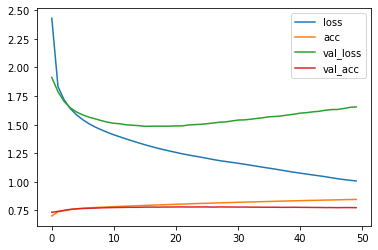

In [ ]:
pd.DataFrame(history.history).plot()
plt.savefig('seq_score.png')
plt.show()

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [ ]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Load Model & Prediction

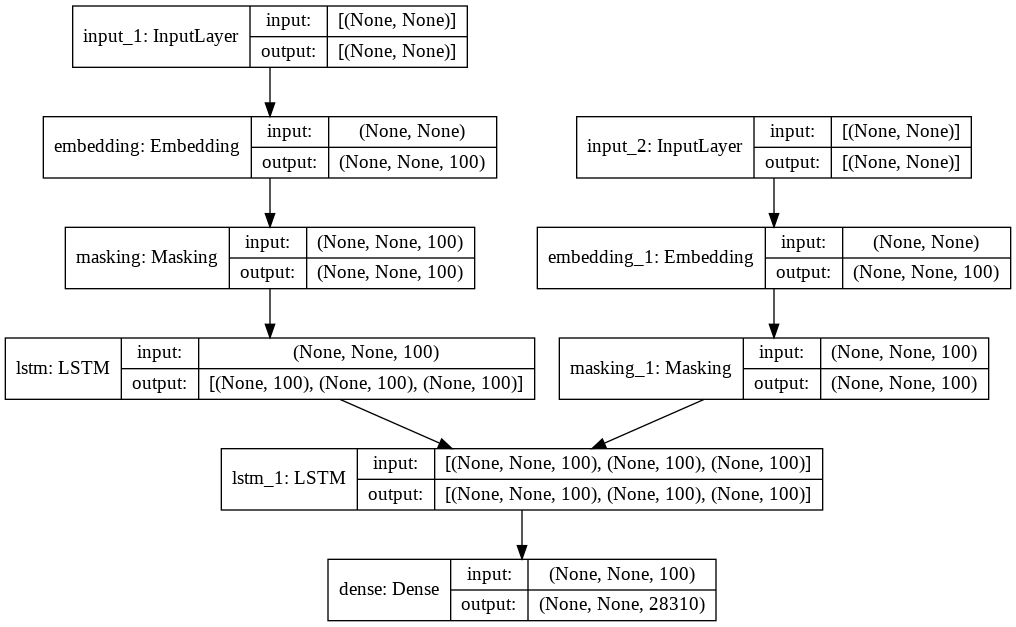

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.load_weights('./drive/My Drive/comic_trans_project/checkpoints/seq_komoran.hdf5')
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
tf.keras.utils.plot_model(
    model, to_file='seq_komoran.png', show_shapes=True)

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [ ]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = eng_dict['<S>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = output_dict[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<EOS>' or
           len(decoded_sentence) > 70):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + input_dict[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=eng_dict['<S>']) and i!=eng_dict['<EOS>']):
            temp = temp + output_dict[i] + ' '
    return temp

In [ ]:
kor2eng_compare = kor2eng.iloc[indices,:]
kor2eng_train = kor2eng_compare[:-n_of_val]
kor2eng_test = kor2eng_compare[-n_of_val:]
kor2eng_train.reset_index(drop=True,inplace=True)
kor2eng_test.reset_index(drop=True,inplace=True)

In [ ]:
def compare_prediction(encoder_data, raw_data, limit=20):
    # evaluate a model
    compare_df = pd.DataFrame(columns=['Korean','English','Translated'])
    for i, vector in enumerate(encoder_data): # translate encoded source text
        input_seq = encoder_data[i: i + 1]
        decoded_sentence = decode_sequence(input_seq)
        compare_df = compare_df.append(pd.DataFrame([[raw_data['Korean'][i], raw_data['English'][i], decoded_sentence[:-5]]], columns=['Korean','English','Translated']), ignore_index=True)
        if i >= limit: # Display some of the result
           break
    return compare_df

In [ ]:
# test on some training sequences
print('### Result on the Training Set ###')
compare_train = compare_prediction(encoder_input_train, kor2eng_train)
compare_train.to_csv('compare_seq_train', mode='w')

### Result on the Training Set ###


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
# test on some training sequences
print('### Result on the Training Set ###')
compare_test = compare_prediction(encoder_input_test, kor2eng_test)
compare_test.to_csv('compare_seq_test', mode='w')

### Result on the Training Set ###


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ", kor2eng_train['Korean'][seq_index])
  print("번역문 :",kor2eng_train['English'][seq_index])
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


원문 :  그녀는 침실에서 아래층으로 내려갔다.
번역문 : she came down the stairs from her bedroom.
예측문 :  she the my hands of the sun . 


원문 :  그녀의 인자하고 선량한 인품에 대해 우리는 영원히 마음 속에 기억할 것이다.
번역문 : i shall always remember her kindness and cleverness.
예측문 :  i 'm always the same as to know her as his as a friend was like him . 


원문 :  아버지의 죽음은 나로 하여금 맥이 빠짐을 느끼게 했다.
번역문 : i was unmanned by the death of my father.
예측문 :  father 's mother 's a heart . 


원문 :  나는 맥주 10병을 능히 마실 수 있다.
번역문 : i can drink ten bottles of beer.
예측문 :  i have my coffee is easily . 


원문 :  나는 세 숟가락의 밀가루와 한 숟가락의 설탕을 이용했다.
번역문 : i used three scoops of flour and oneof sugar.
예측문 :  i usually have made a red half a month and then he had to put up a




In [ ]:
for seq_index in [1,40,111,500,1000]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ", kor2eng_test['Korean'][seq_index])
  print("번역문 :",kor2eng_test['English'][seq_index])
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


원문 :  이 탕은 생선 비린내가 난다.
번역문 : this soup has a savour of fish.
예측문 :  this tree is easily . 


원문 :  그들이 소식을 그에게 전했을 때 그는 조금도 동요하지 않았다.
번역문 : he displayed no feelings when they told him the news.
예측문 :  they told him that he had the door to be a baby . 


원문 :  정찰병은 주력부대의 앞에 갔다가 돌와와 적군의 실제상황을 보고했다.
번역문 : the scouts went ahead of the main force and reported back the strength of the enemy.
예측문 :  the whole army was called in for the enemy and we all had to the 


원문 :  일요일날 너는 집에서 밥을 먹니?
번역문 : do you dine in on sundays?
예측문 :  are there a time to get back this week ? 


원문 :  이 아이는 그의 부모에게 있어서 고통스런 존재이다.
번역문 : that child is a torment to his parents.
예측문 :  the child is a his wife 's son 's own is very long . 




# BLEU Score

In [ ]:
# It takes long to compute the BLEU Score

def bleu_score(encoder, raw_data):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, sentence in enumerate(encoder[:1000]):
        # translate encoded source text
        input_seq = encoder[i: i + 1]
        translation = decode_sequence(input_seq)
        translation = translation[:-5]
        target= raw_data['English'][i]
        actual.append([target.split()])
        predicted.append(translation.split())
    bleu_dic = {}
    bleu_dic['1-grams'] = bleu.corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = bleu.corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu_dic

# Compute the BLEU Score
bleu_train = bleu_score(encoder_input_train, kor2eng_train)
bleu_test = bleu_score(encoder_input_test, kor2eng_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


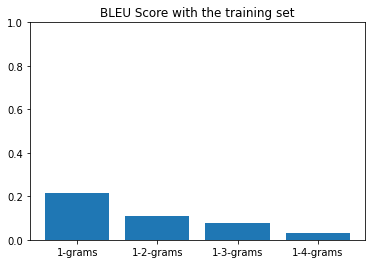

In [ ]:
plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU Score with the training set")
plt.ylim((0,1))
plt.savefig('bleu_train_seq.png', dpi=300)
plt.show()

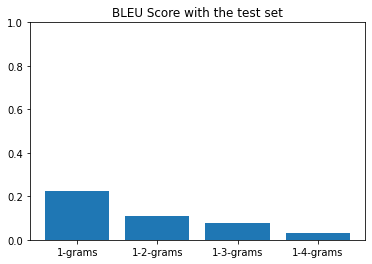

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.savefig('bleu_test_seq.png', dpi=300)
plt.show()

In [ ]:
print(bleu_train)
print(bleu_test)

{'1-grams': 0.21683515576645349, '1-2-grams': 0.10734356584204724, '1-3-grams': 0.0754087434621084, '1-4-grams': 0.029228593814761467}
{'1-grams': 0.22405391394504925, '1-2-grams': 0.1102504041114384, '1-3-grams': 0.07789721002862962, '1-4-grams': 0.0313907264552576}


# CV

In [ ]:
!wandb login eb738ba304b560fc8b41bf28ba686d71a2b3d5d4
wandb_project = "seq_komoran_cv"
wandb_group = "seq_komoran_cv"

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project=wandb_project) 
wandb_callback = WandbCallback()

In [ ]:
kfold = KFold(n_splits=3, shuffle=True)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train, test in kfold.split(encoder_input, decoder_input, decoder_target):

  save_best = keras.callbacks.ModelCheckpoint(filepath=f'./drive/My Drive/comic_trans_project/checkpoints/seq_komoran_fold-%i.h5'%fold_no, monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch', options=None)
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(x = [encoder_input[train],decoder_input[train]], y = decoder_target[train], batch_size = 128, epochs = 1, callbacks=[save_best, wandb_callback])
  # Generate generalization metrics
  scores = model.evaluate(x=[encoder_input[test],decoder_input[test]], y = decoder_target[test], verbose=1)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


316/316 [==============================] - 30s 94ms/step - loss: 1.2383 - acc: 0.8083

Epoch 00001: loss improved from inf to 1.23831, saving model to ./drive/My Drive/comic_trans_project/checkpoints/seq_komoran_fold-1.h5
631/631 [==============================] - 30s 48ms/step - loss: 1.2597 - acc: 0.8045
Score for fold 1: loss of 1.259741187095642; acc of 80.45094609260559%
------------------------------------------------------------------------
Training for fold 2 ...
316/316 [==============================] - 30s 94ms/step - loss: 1.2439 - acc: 0.8078

Epoch 00001: loss improved from inf to 1.24390, saving model to ./drive/My Drive/comic_trans_project/checkpoints/seq_komoran_fold-2.h5
631/631 [==============================] - 29s 47ms/step - loss: 1.2419 - acc: 0.8077
Score for fold 2: loss of 1.2419222593307495; acc of 80.7736337184906%
------------------------------------------------------------------------
Training for fold 3 ...
316/316 [==============================] - 29s 9

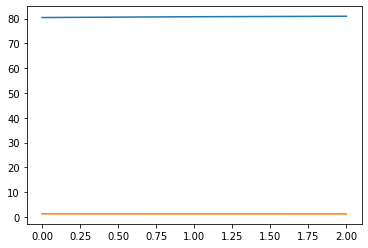

In [ ]:
plt.plot(acc_per_fold);
plt.plot(loss_per_fold);